# Imports

In [2]:
import numpy as np
from datetime import datetime
import time
import os
from imageio import imwrite

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torch import autograd

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from torch.nn.modules.batchnorm import BatchNorm2d

%load_ext tensorboard

# check if CUDA is available
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DIR_PATH = '/content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526'

CUDA is available!  Training on GPU ...


# Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

drive_path = '/content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526'

print('Drive Path : ' + drive_path)

Mounted at /content/drive/
Drive Path : /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526


# Define models Consts

In [4]:
DIM = 64
BATCH_SIZE = 64
NOISE_SIZE = 128
GEN_ITER = 20000
DISC_ITER = 5
IMAGE_SIZE = 28
OUTPUT_TOT_SIZE = 784  # Fashion MNIST size (28, 28)
IMAGE_CHANNELS = 1
LAMBDA = 10 # Gradient penalty hyper-parameter
VALID_SIZE = 0.2
NUM_WORKERS = 1
PRINT_EVERY = 100
IMG_SAVE_EVERY = 1000


ONE = torch.tensor(1).to(DEVICE)
MINUS_ONE = torch.tensor(-1).to(DEVICE)
REAL_LABEL = torch.tensor(1).to(DEVICE)
FAKE_LABEL = torch.tensor(0).to(DEVICE)

# Load Data

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root=os.path.join(drive_path), 
                                      train=True,
                                      transform=transform,
                                      download=True)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/FashionMNIST/raw



# Visualize a batch of training data

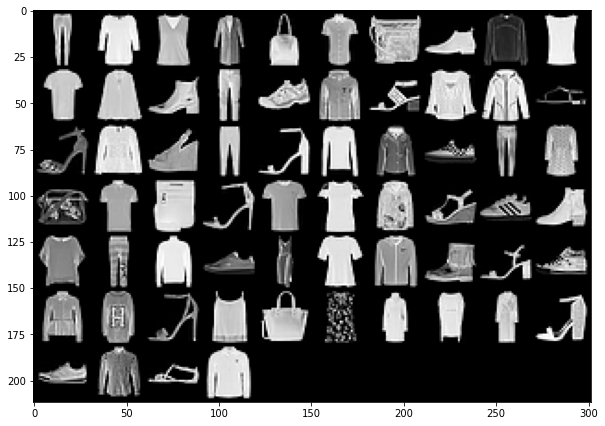

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

def visualize_batch(image_batch, save_path=None):
    plt.figure(figsize=(10,10))
    grid = torchvision.utils.make_grid(tensor=image_batch.reshape(-1, 1, IMAGE_SIZE, IMAGE_SIZE), nrow=10)
    grid = np.clip(grid,0,1).numpy()
    if save_path is None:
        plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");
    else:
        imwrite(save_path, np.transpose(grid, axes=(1,2,0)))
    
image_dir = os.path.join(drive_path, 'images')
os.makedirs(image_dir, exist_ok=True)
image_path = os.path.join(image_dir, 'test.png')
visualize_batch(images)

# Define GAN Model

In [17]:

class Generator(nn.Module):
  def __init__(self, mode, kernel_size_1=5, kernel_size_2=5, kernel_size_3=8):
    super().__init__()
    self.mode = mode
    self.fc1 = nn.Sequential(
        nn.Linear(NOISE_SIZE, 4 * 4 * 4 * DIM),
        nn.BatchNorm1d(4 * 4 * 4 * DIM) if mode == 'wgan-gp' else nn.Identity(),
        nn.ReLU(True)
        )
    
    self.pre_activate1 = nn.Sequential(
        nn.ConvTranspose2d(4 * DIM, 2 * DIM, kernel_size_1),
        nn.BatchNorm2d(2 * DIM) if mode == 'wgan-gp' else nn.Identity(),
        nn.ReLU(True)
    )

    self.pre_activate2 = nn.Sequential(
        nn.ConvTranspose2d(2 * DIM, DIM, kernel_size_2),
        nn.BatchNorm2d(DIM) if mode == 'wgan-gp' else nn.Identity(),
        nn.ReLU(True)
    )

    self.pre_activate3 = nn.ConvTranspose2d(DIM, IMAGE_CHANNELS, kernel_size_3, stride=2)

    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    output = self.fc1(input)
    output = output.view(-1, 4 * DIM, 4, 4)
    # print(output.size())
    output = self.pre_activate1(output)
    # print(output.size())
    output = output[:, :, :7, :7]
    # print(output.size())
    output = self.pre_activate2(output)
    # print(output.size())
    output = self.pre_activate3(output)
    # print(output.size())
    output = self.sigmoid(output)
    return output.view(-1, OUTPUT_TOT_SIZE)

# --------------------------------------------------------------------------------------------------
class Discriminator(nn.Module):
  def __init__(self, mode, kernel_size=5):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(IMAGE_CHANNELS, DIM, kernel_size, stride=2, padding=2),
        nn.ReLU(True)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(DIM, 2 * DIM, kernel_size, stride=2, padding=2),
        nn.ReLU(True)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(2 * DIM, 4 * DIM, kernel_size, stride=2, padding=2),
        nn.ReLU(True)
    )

    self.fc = nn.Linear(4 * 4 * 4 * DIM, 1)

  def forward(self, input):
    input = input.view(-1, 1, IMAGE_SIZE, IMAGE_SIZE)
    output = self.conv1(input)
    # print(output.size())
    output = self.conv2(output)
    # print(output.size())
    output = self.conv3(output)
    # print(output.size())
    output = output.view(-1, 4 * 4 * 4 * DIM)
    # print(output.size())
    output = self.fc(output)
    # print(output.size())
    return output.view(-1)

# --------------------------------------------------------------------------------------------------
def calc_gradient_penalty(disc_net, real_data, fake_data):
    real_data = real_data.reshape(fake_data.size())
    eps = torch.rand(BATCH_SIZE, 1)
    eps = eps.expand(real_data.size())
    eps = eps.to(DEVICE) if is_gpu_available else eps

    interpolates = eps * real_data + ((1 - eps) * fake_data)

    if is_gpu_available:
        interpolates = interpolates.to(DEVICE)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = disc_net(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(DEVICE) if is_gpu_available
                              else torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty


# Functions for Training

## Generate fake image

In [8]:
def generate_fake_image(gen_net):
    with torch.no_grad():
        noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
        if is_gpu_available:
            noise = noise.to(DEVICE)
    fake_images = gen_net(noise)
    fake_images = fake_images.view(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE)
    return fake_images


## Train Discriminator

In [9]:
def train_disc_net(gen_net, disc_net, real_data_gen, disc_opt, mode='wgan-gp', loss=None, disc_iter=DISC_ITER):
    dataiter = iter(real_data_gen)
    for iteration in range(disc_iter):

        # Train with real data
        data_images, _ = dataiter.next()
        real_data = torch.Tensor(data_images)
        if torch.cuda.is_available():
            real_data = real_data.to(DEVICE)
        real_data_var = autograd.Variable(real_data)

        disc_net.zero_grad()

        disc_out_real = disc_net(real_data_var)
        if mode == 'wgan-gp':
            disc_out_real = disc_out_real.mean()
            disc_out_real.backward(MINUS_ONE)
        elif mode == 'dcgan':
            real_label = REAL_LABEL.expand(disc_out_real.size())
            disc_loss = loss(disc_out_real, real_label)
        else:
            raise NotImplementedError("Allowed modes are: 'dcgan'/'wgan-gp'. {} is not implemented".format(mode))

        # Train with fake data
        with torch.no_grad():
            noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
            if is_gpu_available:
                noise = noise.to(DEVICE)
        fake_images = gen_net(noise)
        fake_images = autograd.Variable(fake_images.data)
        disc_in_images = fake_images
        disc_out_fake = disc_net(disc_in_images)

        # train with gradient penalty
        if mode == 'wgan-gp':
            disc_out_fake = disc_out_fake.mean()
            disc_out_fake.backward(ONE)
            gradient_penalty = calc_gradient_penalty(disc_net, real_data_var.data, fake_images.data)
            gradient_penalty.backward()
            disc_loss = disc_out_fake - disc_out_real + gradient_penalty

        elif mode == 'dcgan':
            fake_label = FAKE_LABEL.expand(disc_out_fake.size())
            disc_loss += loss(disc_out_fake, fake_label)
            disc_loss = disc_loss.mean() / 2
            disc_loss.backward()

        else:
            raise NotImplementedError("Allowed modes are: 'dcgan'/'wgan-gp'. {} is not implemented".format(mode))

        disc_opt.step()

    return gen_net, disc_net, disc_opt, disc_loss

## Train Generator

In [10]:
def train_gen_net(gen_net, disc_net, gen_opt, mode='wgan-gp', loss=None):
    gen_net.zero_grad()

    noise = torch.randn(BATCH_SIZE, NOISE_SIZE)
    if torch.cuda.is_available():
        noise = noise.to(DEVICE)
    noise_var = autograd.Variable(noise)
    gen_out = gen_net(noise_var)
    net_out = disc_net(gen_out)

    if mode == 'wgan-gp':
        gen_loss = net_out.mean()
        gen_loss.backward(MINUS_ONE)
        gen_loss = -gen_loss

    elif mode == 'dcgan':
        real_label = REAL_LABEL.expand(net_out.size())
        gen_loss = loss(net_out, real_label)
        gen_loss = gen_loss.mean()
        gen_loss.backward()

    else:
        raise NotImplementedError("Allowed modes are: 'dcgan'/'wgan-gp'. {} is not implemented".format(mode))

    gen_opt.step()
    return gen_net, disc_net, gen_opt, gen_loss

## Full training function

In [11]:
def train_loop(gen_net,
               disc_net,
               gen_opt,
               disc_opt,
               train_gen,
               mode='wgan-gp',
               disc_iter=DISC_ITER,
               ckpt_path: str = None,
               img_dir: str = None):
    results = {'train_generator_loss': [], 'train_discriminator_loss': []}
    best_disc_loss = np.inf
    loss = nn.BCELoss() if mode == 'dcgan' else None
    for iteration in range(GEN_ITER):
        start_time = time.time()

        for p in disc_net.parameters():
            p.requires_grad = True
        for p in gen_net.parameters():  # reset requires_grad
            p.requires_grad = False

        gen_net, disc_net, disc_opt, disc_loss = train_disc_net(gen_net,
                                                                disc_net,
                                                                train_gen,
                                                                disc_opt,
                                                                disc_iter=disc_iter,
                                                                loss=loss)

        for p in disc_net.parameters():  # reset requires_grad
            p.requires_grad = False
        for p in gen_net.parameters():
            p.requires_grad = True

        gen_net, disc_net, gen_opt, gen_loss = train_gen_net(gen_net, disc_net, gen_opt, loss=loss)
        
        results['train_generator_loss'].append(np.abs(gen_loss.cpu().detach().numpy()))
        results['train_discriminator_loss'].append(np.abs(disc_loss.cpu().detach().numpy()))

        if iteration % PRINT_EVERY == (PRINT_EVERY - 1):
            elapsed = time.time() - start_time
            print('[{}/{}]\tGenerator Loss: {:.3f}\tDiscriminator Loss: {:.3f} | ms/iteration: {:.4f}'.format(
                iteration,
                GEN_ITER,
                results['train_generator_loss'][-1],
                results['train_discriminator_loss'][-1],
                elapsed / PRINT_EVERY))
            
            if ckpt_path is not None and results['train_discriminator_loss'][-1] < best_disc_loss:
                best_disc_loss = results['train_discriminator_loss'][-1]
                save_model(gen_net, disc_net, gen_opt, disc_opt, ckpt_path)
                print('models saved to {}'.format(ckpt_path))

            images = generate_fake_image(gen_net)
            if iteration % IMG_SAVE_EVERY == (IMG_SAVE_EVERY - 1):
                visualize_batch(images.cpu(), save_path=os.path.join(img_dir, 'sample_{}.png'.format(iteration)))
    return gen_net, disc_net, gen_opt, disc_opt, results

# Save & Plot Functions

In [12]:
# Plot Convergence Graph
def plot_results(gen_loss, disc_loss, num_iters, title):

    gen_loss = np.array(gen_loss) 
    disc_loss = np.array(disc_loss)

    plt.plot(np.arange(1, num_iters+1), gen_loss)
    plt.plot(np.arange(1, num_iters+1), disc_loss)
    plt.legend(('Generator Loss', 'Disriminator Loss'), loc='upper right')
    plt.ylabel('Loss')
    plt.xlabel('Iteration #')
    plt.title(title)
    plt.grid()
    plt.show()

# --------------------------------------------------------------------------------------------------
def save_model(gen_net, disc_net, gen_opt, disc_opt, ckpt_path):
    torch.save({
        'generator_state_dict': gen_net.state_dict(),
        'generator_optimizer_state_dict': gen_opt.state_dict(),
        'discriminator_state_dict': disc_net.state_dict(),
        'discriminator_optimizer_state_dict': disc_opt.state_dict(),
    }, ckpt_path)
    
# --------------------------------------------------------------------------------------------------

def train_and_save(train_data,
                   gen_net,
                   disc_net,
                   gen_opt,
                   disc_opt,
                   disc_iter=DISC_ITER,
                   model_type='wgan-gp'):

    # Print Model
    print(gen_net)
    print(disc_net)

    # Set ransom seed
    RANDOM_SEED = 13
    torch.manual_seed(RANDOM_SEED)
    
    curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
    model_name = f'{curr_datetime}_{model_type}'

    # create checkpints folder
    ckpt_dir = os.path.join(drive_path, 'Q4_GAN', 'checkpoints')
    os.makedirs(ckpt_dir, exist_ok=True)
    ckpt_path = os.path.join(ckpt_dir, f'{model_name}.ckpt')

    # create images folder
    img_dir = os.path.join(drive_path, 'Q4_GAN', f'images/{model_name}')
    os.makedirs(img_dir, exist_ok=True)

    # train
    print("Training Start\n")
    gen_net, disc_net, gen_opt, disc_opt, results = train_loop(gen_net,
                                                               disc_net,
                                                               gen_opt,
                                                               disc_opt,
                                                               train_data,
                                                               mode=model_type,
                                                               disc_iter=disc_iter,
                                                               ckpt_path=ckpt_path,
                                                               img_dir=img_dir)
    return results

# Train the network

## DCGAN

Generator(
  (fc1): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): Identity()
    (2): ReLU(inplace=True)
  )
  (pre_activate1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): Identity()
    (2): ReLU(inplace=True)
  )
  (pre_activate2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): Identity()
    (2): ReLU(inplace=True)
  )
  (pre_activate3): ConvTranspose2d(64, 1, kernel_size=(8, 8), stride=(2, 2))
  (sigmoid): Sigmoid()
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
  )
  (fc): Linear(in_features=4096, out_fe

[999/20000]	Generator Loss: 2.186	Discriminator Loss: 3.360 | ms/iteration: 0.0004
[1099/20000]	Generator Loss: 0.764	Discriminator Loss: 5.669 | ms/iteration: 0.0004
[1199/20000]	Generator Loss: 0.201	Discriminator Loss: 6.484 | ms/iteration: 0.0003
[1299/20000]	Generator Loss: 7.297	Discriminator Loss: 4.518 | ms/iteration: 0.0003
[1399/20000]	Generator Loss: 1.391	Discriminator Loss: 3.610 | ms/iteration: 0.0004
[1499/20000]	Generator Loss: 0.941	Discriminator Loss: 2.620 | ms/iteration: 0.0004
[1599/20000]	Generator Loss: 2.217	Discriminator Loss: 4.190 | ms/iteration: 0.0004
[1699/20000]	Generator Loss: 5.109	Discriminator Loss: 4.315 | ms/iteration: 0.0003
[1799/20000]	Generator Loss: 8.001	Discriminator Loss: 4.436 | ms/iteration: 0.0003
[1899/20000]	Generator Loss: 9.017	Discriminator Loss: 2.992 | ms/iteration: 0.0003


[1999/20000]	Generator Loss: 0.872	Discriminator Loss: 4.526 | ms/iteration: 0.0004
[2099/20000]	Generator Loss: 2.612	Discriminator Loss: 4.356 | ms/iteration: 0.0003
[2199/20000]	Generator Loss: 1.182	Discriminator Loss: 3.565 | ms/iteration: 0.0004
[2299/20000]	Generator Loss: 9.011	Discriminator Loss: 5.090 | ms/iteration: 0.0004
[2399/20000]	Generator Loss: 8.369	Discriminator Loss: 3.803 | ms/iteration: 0.0003
[2499/20000]	Generator Loss: 2.676	Discriminator Loss: 1.893 | ms/iteration: 0.0004
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:02:10_dcgan.ckpt
[2599/20000]	Generator Loss: 2.736	Discriminator Loss: 4.042 | ms/iteration: 0.0003
[2699/20000]	Generator Loss: 4.933	Discriminator Loss: 3.390 | ms/iteration: 0.0003
[2799/20000]	Generator Loss: 0.272	Discriminator Loss: 3.576 | ms/iteration: 0.0003
[2899/20000]	Generator Loss: 2.289	Discriminator Loss: 3.209 | ms/iteration: 0.0003


[2999/20000]	Generator Loss: 6.688	Discriminator Loss: 2.819 | ms/iteration: 0.0004
[3099/20000]	Generator Loss: 4.879	Discriminator Loss: 3.010 | ms/iteration: 0.0004
[3199/20000]	Generator Loss: 5.780	Discriminator Loss: 2.925 | ms/iteration: 0.0004
[3299/20000]	Generator Loss: 0.032	Discriminator Loss: 3.766 | ms/iteration: 0.0004
[3399/20000]	Generator Loss: 5.837	Discriminator Loss: 3.917 | ms/iteration: 0.0004
[3499/20000]	Generator Loss: 1.009	Discriminator Loss: 3.049 | ms/iteration: 0.0004
[3599/20000]	Generator Loss: 0.787	Discriminator Loss: 2.032 | ms/iteration: 0.0003
[3699/20000]	Generator Loss: 0.237	Discriminator Loss: 3.920 | ms/iteration: 0.0003
[3799/20000]	Generator Loss: 2.482	Discriminator Loss: 3.194 | ms/iteration: 0.0004
[3899/20000]	Generator Loss: 0.837	Discriminator Loss: 3.610 | ms/iteration: 0.0004


[3999/20000]	Generator Loss: 1.346	Discriminator Loss: 4.220 | ms/iteration: 0.0003
[4099/20000]	Generator Loss: 9.893	Discriminator Loss: 2.863 | ms/iteration: 0.0004
[4199/20000]	Generator Loss: 0.585	Discriminator Loss: 1.597 | ms/iteration: 0.0004
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:02:10_dcgan.ckpt
[4299/20000]	Generator Loss: 10.339	Discriminator Loss: 1.428 | ms/iteration: 0.0003
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:02:10_dcgan.ckpt
[4399/20000]	Generator Loss: 1.295	Discriminator Loss: 1.472 | ms/iteration: 0.0004
[4499/20000]	Generator Loss: 1.072	Discriminator Loss: 3.189 | ms/iteration: 0.0003
[4599/20000]	Generator Loss: 0.713	Discriminator Loss: 2.727 | ms/iteration: 0.0004
[4699/20000]	Generator Loss: 0.248	Discriminator Loss: 2.381 | ms/iteration: 0.0003
[4799/20000]	Generator Loss: 0.928	Discriminator Loss: 2.00

[4999/20000]	Generator Loss: 4.415	Discriminator Loss: 1.914 | ms/iteration: 0.0004
[5099/20000]	Generator Loss: 5.378	Discriminator Loss: 1.654 | ms/iteration: 0.0003
[5199/20000]	Generator Loss: 3.003	Discriminator Loss: 3.036 | ms/iteration: 0.0004
[5299/20000]	Generator Loss: 1.013	Discriminator Loss: 2.214 | ms/iteration: 0.0004
[5399/20000]	Generator Loss: 0.812	Discriminator Loss: 2.798 | ms/iteration: 0.0003
[5499/20000]	Generator Loss: 1.670	Discriminator Loss: 1.741 | ms/iteration: 0.0003
[5599/20000]	Generator Loss: 0.360	Discriminator Loss: 1.882 | ms/iteration: 0.0004
[5699/20000]	Generator Loss: 0.015	Discriminator Loss: 2.219 | ms/iteration: 0.0004
[5799/20000]	Generator Loss: 0.452	Discriminator Loss: 1.934 | ms/iteration: 0.0003
[5899/20000]	Generator Loss: 3.332	Discriminator Loss: 2.128 | ms/iteration: 0.0003


[5999/20000]	Generator Loss: 2.343	Discriminator Loss: 2.071 | ms/iteration: 0.0004
[6099/20000]	Generator Loss: 4.289	Discriminator Loss: 1.510 | ms/iteration: 0.0003
[6199/20000]	Generator Loss: 3.594	Discriminator Loss: 2.426 | ms/iteration: 0.0004
[6299/20000]	Generator Loss: 1.576	Discriminator Loss: 1.399 | ms/iteration: 0.0004
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:02:10_dcgan.ckpt
[6399/20000]	Generator Loss: 2.746	Discriminator Loss: 1.788 | ms/iteration: 0.0004
[6499/20000]	Generator Loss: 2.631	Discriminator Loss: 2.344 | ms/iteration: 0.0003
[6599/20000]	Generator Loss: 6.810	Discriminator Loss: 1.121 | ms/iteration: 0.0004
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:02:10_dcgan.ckpt
[6699/20000]	Generator Loss: 1.459	Discriminator Loss: 2.268 | ms/iteration: 0.0004
[6799/20000]	Generator Loss: 2.743	Discriminator Loss: 1.608

[6999/20000]	Generator Loss: 4.964	Discriminator Loss: 1.845 | ms/iteration: 0.0004
[7099/20000]	Generator Loss: 0.153	Discriminator Loss: 0.965 | ms/iteration: 0.0003
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:02:10_dcgan.ckpt
[7199/20000]	Generator Loss: 1.134	Discriminator Loss: 1.285 | ms/iteration: 0.0003
[7299/20000]	Generator Loss: 0.455	Discriminator Loss: 1.123 | ms/iteration: 0.0003
[7399/20000]	Generator Loss: 6.223	Discriminator Loss: 2.013 | ms/iteration: 0.0004
[7499/20000]	Generator Loss: 1.629	Discriminator Loss: 1.830 | ms/iteration: 0.0004
[7599/20000]	Generator Loss: 2.976	Discriminator Loss: 1.642 | ms/iteration: 0.0003
[7699/20000]	Generator Loss: 1.120	Discriminator Loss: 1.431 | ms/iteration: 0.0003
[7799/20000]	Generator Loss: 2.056	Discriminator Loss: 1.272 | ms/iteration: 0.0004
[7899/20000]	Generator Loss: 0.711	Discriminator Loss: 1.090 | ms/iteration: 0.0004


[7999/20000]	Generator Loss: 2.862	Discriminator Loss: 0.442 | ms/iteration: 0.0004
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:02:10_dcgan.ckpt
[8099/20000]	Generator Loss: 3.166	Discriminator Loss: 1.433 | ms/iteration: 0.0003
[8199/20000]	Generator Loss: 0.020	Discriminator Loss: 1.249 | ms/iteration: 0.0003
[8299/20000]	Generator Loss: 0.828	Discriminator Loss: 1.293 | ms/iteration: 0.0003
[8399/20000]	Generator Loss: 0.016	Discriminator Loss: 1.574 | ms/iteration: 0.0004
[8499/20000]	Generator Loss: 1.770	Discriminator Loss: 1.126 | ms/iteration: 0.0004
[8599/20000]	Generator Loss: 1.820	Discriminator Loss: 1.369 | ms/iteration: 0.0003
[8699/20000]	Generator Loss: 3.193	Discriminator Loss: 1.226 | ms/iteration: 0.0004
[8799/20000]	Generator Loss: 1.326	Discriminator Loss: 1.260 | ms/iteration: 0.0003
[8899/20000]	Generator Loss: 2.499	Discriminator Loss: 0.843 | ms/iteration: 0.0003


[8999/20000]	Generator Loss: 0.819	Discriminator Loss: 0.822 | ms/iteration: 0.0004
[9099/20000]	Generator Loss: 2.453	Discriminator Loss: 1.497 | ms/iteration: 0.0003
[9199/20000]	Generator Loss: 0.226	Discriminator Loss: 1.843 | ms/iteration: 0.0003
[9299/20000]	Generator Loss: 0.770	Discriminator Loss: 0.987 | ms/iteration: 0.0004
[9399/20000]	Generator Loss: 0.332	Discriminator Loss: 1.180 | ms/iteration: 0.0004
[9499/20000]	Generator Loss: 3.183	Discriminator Loss: 1.523 | ms/iteration: 0.0003
[9599/20000]	Generator Loss: 0.948	Discriminator Loss: 1.119 | ms/iteration: 0.0003
[9699/20000]	Generator Loss: 1.977	Discriminator Loss: 1.326 | ms/iteration: 0.0003
[9799/20000]	Generator Loss: 1.175	Discriminator Loss: 1.250 | ms/iteration: 0.0004
[9899/20000]	Generator Loss: 0.744	Discriminator Loss: 1.173 | ms/iteration: 0.0004


[9999/20000]	Generator Loss: 0.128	Discriminator Loss: 1.150 | ms/iteration: 0.0004
[10099/20000]	Generator Loss: 0.969	Discriminator Loss: 1.056 | ms/iteration: 0.0005
[10199/20000]	Generator Loss: 0.622	Discriminator Loss: 1.388 | ms/iteration: 0.0003
[10299/20000]	Generator Loss: 0.261	Discriminator Loss: 0.818 | ms/iteration: 0.0003
[10399/20000]	Generator Loss: 0.394	Discriminator Loss: 1.138 | ms/iteration: 0.0003
[10499/20000]	Generator Loss: 1.340	Discriminator Loss: 1.164 | ms/iteration: 0.0004
[10599/20000]	Generator Loss: 0.447	Discriminator Loss: 1.338 | ms/iteration: 0.0003
[10699/20000]	Generator Loss: 0.173	Discriminator Loss: 1.223 | ms/iteration: 0.0004
[10799/20000]	Generator Loss: 0.636	Discriminator Loss: 1.207 | ms/iteration: 0.0004
[10899/20000]	Generator Loss: 0.217	Discriminator Loss: 1.480 | ms/iteration: 0.0004


[10999/20000]	Generator Loss: 2.053	Discriminator Loss: 1.192 | ms/iteration: 0.0004
[11099/20000]	Generator Loss: 2.235	Discriminator Loss: 1.112 | ms/iteration: 0.0004
[11199/20000]	Generator Loss: 3.082	Discriminator Loss: 0.969 | ms/iteration: 0.0004
[11299/20000]	Generator Loss: 0.869	Discriminator Loss: 1.090 | ms/iteration: 0.0004
[11399/20000]	Generator Loss: 1.640	Discriminator Loss: 1.270 | ms/iteration: 0.0004
[11499/20000]	Generator Loss: 0.141	Discriminator Loss: 0.928 | ms/iteration: 0.0010
[11599/20000]	Generator Loss: 3.277	Discriminator Loss: 1.678 | ms/iteration: 0.0004
[11699/20000]	Generator Loss: 2.113	Discriminator Loss: 0.796 | ms/iteration: 0.0003
[11799/20000]	Generator Loss: 1.849	Discriminator Loss: 0.694 | ms/iteration: 0.0004
[11899/20000]	Generator Loss: 1.188	Discriminator Loss: 1.053 | ms/iteration: 0.0003


[11999/20000]	Generator Loss: 0.785	Discriminator Loss: 1.069 | ms/iteration: 0.0004
[12099/20000]	Generator Loss: 2.604	Discriminator Loss: 1.238 | ms/iteration: 0.0003
[12199/20000]	Generator Loss: 1.108	Discriminator Loss: 0.964 | ms/iteration: 0.0003
[12299/20000]	Generator Loss: 1.371	Discriminator Loss: 0.819 | ms/iteration: 0.0004
[12399/20000]	Generator Loss: 0.043	Discriminator Loss: 1.395 | ms/iteration: 0.0004
[12499/20000]	Generator Loss: 0.527	Discriminator Loss: 1.522 | ms/iteration: 0.0003
[12599/20000]	Generator Loss: 0.491	Discriminator Loss: 1.298 | ms/iteration: 0.0003
[12699/20000]	Generator Loss: 0.020	Discriminator Loss: 1.081 | ms/iteration: 0.0003
[12799/20000]	Generator Loss: 0.167	Discriminator Loss: 1.083 | ms/iteration: 0.0004
[12899/20000]	Generator Loss: 1.033	Discriminator Loss: 1.124 | ms/iteration: 0.0003


[12999/20000]	Generator Loss: 0.989	Discriminator Loss: 1.031 | ms/iteration: 0.0003
[13099/20000]	Generator Loss: 0.994	Discriminator Loss: 0.856 | ms/iteration: 0.0003
[13199/20000]	Generator Loss: 0.346	Discriminator Loss: 0.925 | ms/iteration: 0.0004
[13299/20000]	Generator Loss: 1.799	Discriminator Loss: 0.597 | ms/iteration: 0.0003
[13399/20000]	Generator Loss: 1.104	Discriminator Loss: 1.244 | ms/iteration: 0.0003
[13499/20000]	Generator Loss: 1.352	Discriminator Loss: 0.941 | ms/iteration: 0.0004
[13599/20000]	Generator Loss: 0.862	Discriminator Loss: 1.163 | ms/iteration: 0.0004
[13699/20000]	Generator Loss: 1.525	Discriminator Loss: 0.879 | ms/iteration: 0.0003
[13799/20000]	Generator Loss: 1.693	Discriminator Loss: 1.039 | ms/iteration: 0.0003
[13899/20000]	Generator Loss: 0.845	Discriminator Loss: 0.920 | ms/iteration: 0.0004


[13999/20000]	Generator Loss: 1.218	Discriminator Loss: 0.990 | ms/iteration: 0.0004
[14099/20000]	Generator Loss: 1.810	Discriminator Loss: 0.967 | ms/iteration: 0.0003
[14199/20000]	Generator Loss: 1.454	Discriminator Loss: 1.156 | ms/iteration: 0.0003
[14299/20000]	Generator Loss: 0.962	Discriminator Loss: 1.286 | ms/iteration: 0.0003
[14399/20000]	Generator Loss: 0.976	Discriminator Loss: 0.653 | ms/iteration: 0.0004
[14499/20000]	Generator Loss: 0.882	Discriminator Loss: 0.951 | ms/iteration: 0.0004
[14599/20000]	Generator Loss: 1.713	Discriminator Loss: 1.161 | ms/iteration: 0.0004
[14699/20000]	Generator Loss: 1.931	Discriminator Loss: 1.062 | ms/iteration: 0.0004
[14799/20000]	Generator Loss: 0.476	Discriminator Loss: 0.758 | ms/iteration: 0.0003
[14899/20000]	Generator Loss: 0.798	Discriminator Loss: 1.273 | ms/iteration: 0.0003


[14999/20000]	Generator Loss: 0.039	Discriminator Loss: 0.760 | ms/iteration: 0.0004
[15099/20000]	Generator Loss: 1.228	Discriminator Loss: 0.895 | ms/iteration: 0.0003
[15199/20000]	Generator Loss: 1.029	Discriminator Loss: 1.228 | ms/iteration: 0.0003
[15299/20000]	Generator Loss: 1.388	Discriminator Loss: 1.074 | ms/iteration: 0.0003
[15399/20000]	Generator Loss: 1.775	Discriminator Loss: 0.794 | ms/iteration: 0.0003
[15499/20000]	Generator Loss: 1.931	Discriminator Loss: 0.987 | ms/iteration: 0.0004
[15599/20000]	Generator Loss: 2.258	Discriminator Loss: 0.990 | ms/iteration: 0.0004
[15699/20000]	Generator Loss: 1.305	Discriminator Loss: 1.206 | ms/iteration: 0.0003
[15799/20000]	Generator Loss: 2.380	Discriminator Loss: 0.931 | ms/iteration: 0.0003
[15899/20000]	Generator Loss: 1.539	Discriminator Loss: 0.998 | ms/iteration: 0.0004


[15999/20000]	Generator Loss: 1.419	Discriminator Loss: 1.090 | ms/iteration: 0.0004
[16099/20000]	Generator Loss: 2.322	Discriminator Loss: 0.869 | ms/iteration: 0.0004
[16199/20000]	Generator Loss: 1.494	Discriminator Loss: 0.770 | ms/iteration: 0.0003
[16299/20000]	Generator Loss: 0.810	Discriminator Loss: 1.085 | ms/iteration: 0.0004
[16399/20000]	Generator Loss: 3.444	Discriminator Loss: 1.421 | ms/iteration: 0.0003
[16499/20000]	Generator Loss: 2.545	Discriminator Loss: 1.064 | ms/iteration: 0.0003
[16599/20000]	Generator Loss: 1.940	Discriminator Loss: 1.007 | ms/iteration: 0.0004
[16699/20000]	Generator Loss: 1.421	Discriminator Loss: 1.033 | ms/iteration: 0.0003
[16799/20000]	Generator Loss: 2.884	Discriminator Loss: 0.868 | ms/iteration: 0.0003
[16899/20000]	Generator Loss: 2.319	Discriminator Loss: 1.056 | ms/iteration: 0.0004


[16999/20000]	Generator Loss: 2.315	Discriminator Loss: 1.065 | ms/iteration: 0.0003
[17099/20000]	Generator Loss: 2.234	Discriminator Loss: 1.070 | ms/iteration: 0.0004
[17199/20000]	Generator Loss: 3.305	Discriminator Loss: 0.998 | ms/iteration: 0.0004
[17299/20000]	Generator Loss: 2.220	Discriminator Loss: 0.903 | ms/iteration: 0.0004
[17399/20000]	Generator Loss: 1.545	Discriminator Loss: 0.754 | ms/iteration: 0.0004
[17499/20000]	Generator Loss: 3.047	Discriminator Loss: 0.930 | ms/iteration: 0.0004
[17599/20000]	Generator Loss: 2.611	Discriminator Loss: 1.229 | ms/iteration: 0.0003
[17699/20000]	Generator Loss: 0.948	Discriminator Loss: 0.864 | ms/iteration: 0.0004
[17799/20000]	Generator Loss: 1.654	Discriminator Loss: 1.227 | ms/iteration: 0.0004
[17899/20000]	Generator Loss: 1.906	Discriminator Loss: 1.093 | ms/iteration: 0.0003


[17999/20000]	Generator Loss: 3.561	Discriminator Loss: 1.225 | ms/iteration: 0.0004
[18099/20000]	Generator Loss: 1.571	Discriminator Loss: 1.024 | ms/iteration: 0.0003
[18199/20000]	Generator Loss: 2.685	Discriminator Loss: 0.789 | ms/iteration: 0.0004
[18299/20000]	Generator Loss: 2.895	Discriminator Loss: 0.882 | ms/iteration: 0.0003
[18399/20000]	Generator Loss: 2.555	Discriminator Loss: 0.934 | ms/iteration: 0.0004
[18499/20000]	Generator Loss: 1.808	Discriminator Loss: 0.985 | ms/iteration: 0.0003
[18599/20000]	Generator Loss: 0.266	Discriminator Loss: 0.591 | ms/iteration: 0.0003
[18699/20000]	Generator Loss: 2.626	Discriminator Loss: 1.032 | ms/iteration: 0.0003
[18799/20000]	Generator Loss: 1.407	Discriminator Loss: 1.091 | ms/iteration: 0.0004
[18899/20000]	Generator Loss: 1.934	Discriminator Loss: 0.822 | ms/iteration: 0.0004


[18999/20000]	Generator Loss: 1.930	Discriminator Loss: 0.684 | ms/iteration: 0.0004
[19099/20000]	Generator Loss: 2.298	Discriminator Loss: 0.778 | ms/iteration: 0.0003
[19199/20000]	Generator Loss: 2.354	Discriminator Loss: 0.752 | ms/iteration: 0.0003
[19299/20000]	Generator Loss: 2.066	Discriminator Loss: 0.830 | ms/iteration: 0.0003
[19399/20000]	Generator Loss: 1.584	Discriminator Loss: 0.834 | ms/iteration: 0.0004
[19499/20000]	Generator Loss: 3.071	Discriminator Loss: 1.144 | ms/iteration: 0.0003
[19599/20000]	Generator Loss: 2.481	Discriminator Loss: 0.811 | ms/iteration: 0.0003
[19699/20000]	Generator Loss: 0.799	Discriminator Loss: 1.017 | ms/iteration: 0.0004
[19799/20000]	Generator Loss: 1.282	Discriminator Loss: 1.040 | ms/iteration: 0.0004
[19899/20000]	Generator Loss: 4.080	Discriminator Loss: 1.191 | ms/iteration: 0.0004


[19999/20000]	Generator Loss: 1.434	Discriminator Loss: 0.993 | ms/iteration: 0.0003


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

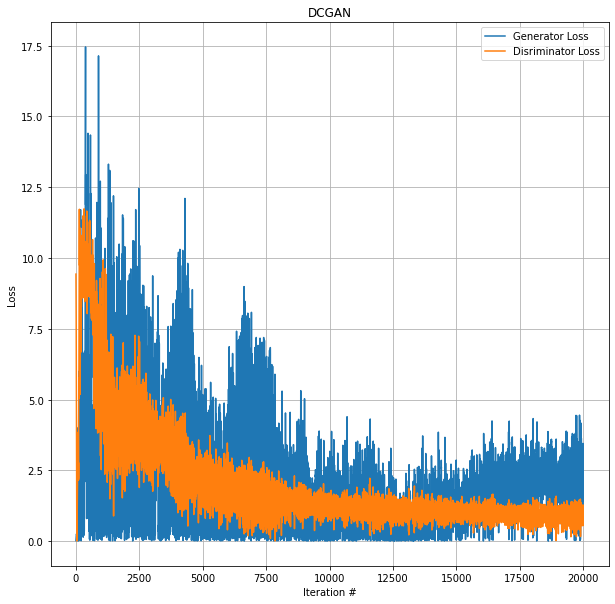

In [18]:
model_type = 'dcgan'
generator = Generator(mode=model_type).to(DEVICE)
discriminator = Discriminator(mode=model_type).to(DEVICE)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=0.8e-4, betas=(0.5, 0.9))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.8e-4, betas=(0.5, 0.9))

results = train_and_save(train_loader, generator, discriminator, gen_optimizer, disc_optimizer, model_type=model_type, disc_iter=1)
plot_results(results['train_generator_loss'], results['train_discriminator_loss'], GEN_ITER, model_type.upper())

## WGAN-GP

Generator(
  (fc1): Sequential(
    (0): Linear(in_features=128, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pre_activate1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pre_activate2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (pre_activate3): ConvTranspose2d(64, 1, kernel_size=(8, 8), stride=(2, 2))
  (sigmoid): Sigmoid()
)
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(

[999/20000]	Generator Loss: 1.693	Discriminator Loss: 2.371 | ms/iteration: 0.0013
[1099/20000]	Generator Loss: 1.051	Discriminator Loss: 2.419 | ms/iteration: 0.0013
[1199/20000]	Generator Loss: 1.347	Discriminator Loss: 2.345 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[1299/20000]	Generator Loss: 1.840	Discriminator Loss: 2.336 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[1399/20000]	Generator Loss: 2.925	Discriminator Loss: 2.481 | ms/iteration: 0.0012
[1499/20000]	Generator Loss: 2.083	Discriminator Loss: 2.328 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[1599/20000]	Generator Loss: 0.685	Discriminator Loss: 2.057 | ms/iteration: 0.0012
model

[1999/20000]	Generator Loss: 2.042	Discriminator Loss: 2.093 | ms/iteration: 0.0012
[2099/20000]	Generator Loss: 0.740	Discriminator Loss: 2.091 | ms/iteration: 0.0012
[2199/20000]	Generator Loss: 0.923	Discriminator Loss: 2.198 | ms/iteration: 0.0012
[2299/20000]	Generator Loss: 0.349	Discriminator Loss: 1.936 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[2399/20000]	Generator Loss: 2.298	Discriminator Loss: 2.019 | ms/iteration: 0.0013
[2499/20000]	Generator Loss: 1.041	Discriminator Loss: 2.098 | ms/iteration: 0.0012
[2599/20000]	Generator Loss: 1.462	Discriminator Loss: 1.900 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[2699/20000]	Generator Loss: 1.842	Discriminator Loss: 1.942 | ms/iteration: 0.0013
[2799/20000]	Generator Loss: 1.746	Discriminator Loss: 1

[2999/20000]	Generator Loss: 0.471	Discriminator Loss: 1.883 | ms/iteration: 0.0012
[3099/20000]	Generator Loss: 1.152	Discriminator Loss: 1.971 | ms/iteration: 0.0012
[3199/20000]	Generator Loss: 0.815	Discriminator Loss: 1.635 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[3299/20000]	Generator Loss: 0.982	Discriminator Loss: 2.109 | ms/iteration: 0.0012
[3399/20000]	Generator Loss: 1.036	Discriminator Loss: 1.999 | ms/iteration: 0.0012
[3499/20000]	Generator Loss: 0.863	Discriminator Loss: 1.734 | ms/iteration: 0.0013
[3599/20000]	Generator Loss: 1.221	Discriminator Loss: 1.979 | ms/iteration: 0.0012
[3699/20000]	Generator Loss: 0.959	Discriminator Loss: 1.548 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[3799/20000]	Generator Loss: 1.415	Discriminator Loss: 1

[3999/20000]	Generator Loss: 1.099	Discriminator Loss: 1.546 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[4099/20000]	Generator Loss: 0.761	Discriminator Loss: 1.660 | ms/iteration: 0.0013
[4199/20000]	Generator Loss: 1.269	Discriminator Loss: 1.696 | ms/iteration: 0.0012
[4299/20000]	Generator Loss: 0.411	Discriminator Loss: 1.642 | ms/iteration: 0.0012
[4399/20000]	Generator Loss: 0.535	Discriminator Loss: 1.643 | ms/iteration: 0.0013
[4499/20000]	Generator Loss: 1.042	Discriminator Loss: 1.698 | ms/iteration: 0.0012
[4599/20000]	Generator Loss: 0.220	Discriminator Loss: 1.733 | ms/iteration: 0.0013
[4699/20000]	Generator Loss: 0.877	Discriminator Loss: 1.591 | ms/iteration: 0.0013
[4799/20000]	Generator Loss: 0.863	Discriminator Loss: 2.093 | ms/iteration: 0.0013
[4899/20000]	Generator Loss: 0.108	Discriminator Loss: 1.712 | ms/iteration: 0.0013


[4999/20000]	Generator Loss: 0.800	Discriminator Loss: 1.635 | ms/iteration: 0.0012
[5099/20000]	Generator Loss: 0.940	Discriminator Loss: 1.600 | ms/iteration: 0.0012
[5199/20000]	Generator Loss: 0.335	Discriminator Loss: 1.584 | ms/iteration: 0.0012
[5299/20000]	Generator Loss: 0.494	Discriminator Loss: 1.422 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[5399/20000]	Generator Loss: 0.460	Discriminator Loss: 1.275 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[5499/20000]	Generator Loss: 0.492	Discriminator Loss: 1.640 | ms/iteration: 0.0012
[5599/20000]	Generator Loss: 1.266	Discriminator Loss: 1.534 | ms/iteration: 0.0012
[5699/20000]	Generator Loss: 0.441	Discriminator Loss: 1.510 | ms/iteration: 0.0013
[5799/20000]	Generator Loss: 0.648	Discriminator Loss: 1

[5999/20000]	Generator Loss: 0.673	Discriminator Loss: 1.691 | ms/iteration: 0.0012
[6099/20000]	Generator Loss: 0.468	Discriminator Loss: 1.795 | ms/iteration: 0.0013
[6199/20000]	Generator Loss: 1.152	Discriminator Loss: 1.221 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[6299/20000]	Generator Loss: 0.159	Discriminator Loss: 1.548 | ms/iteration: 0.0013
[6399/20000]	Generator Loss: 0.086	Discriminator Loss: 1.672 | ms/iteration: 0.0013
[6499/20000]	Generator Loss: 0.023	Discriminator Loss: 1.420 | ms/iteration: 0.0012
[6599/20000]	Generator Loss: 0.627	Discriminator Loss: 1.280 | ms/iteration: 0.0013
[6699/20000]	Generator Loss: 0.605	Discriminator Loss: 1.410 | ms/iteration: 0.0013
[6799/20000]	Generator Loss: 0.509	Discriminator Loss: 1.399 | ms/iteration: 0.0013
[6899/20000]	Generator Loss: 0.654	Discriminator Loss: 1.289 | ms/iteration: 0.0012


[6999/20000]	Generator Loss: 0.580	Discriminator Loss: 1.410 | ms/iteration: 0.0013
[7099/20000]	Generator Loss: 0.422	Discriminator Loss: 1.274 | ms/iteration: 0.0013
[7199/20000]	Generator Loss: 0.746	Discriminator Loss: 1.262 | ms/iteration: 0.0013
[7299/20000]	Generator Loss: 0.084	Discriminator Loss: 1.130 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[7399/20000]	Generator Loss: 0.633	Discriminator Loss: 1.411 | ms/iteration: 0.0013
[7499/20000]	Generator Loss: 0.101	Discriminator Loss: 1.640 | ms/iteration: 0.0012
[7599/20000]	Generator Loss: 0.157	Discriminator Loss: 1.160 | ms/iteration: 0.0012
[7699/20000]	Generator Loss: 0.615	Discriminator Loss: 1.615 | ms/iteration: 0.0013
[7799/20000]	Generator Loss: 0.856	Discriminator Loss: 1.346 | ms/iteration: 0.0013
[7899/20000]	Generator Loss: 0.132	Discriminator Loss: 1.530 | ms/iteration: 0.0012


[7999/20000]	Generator Loss: 0.276	Discriminator Loss: 1.358 | ms/iteration: 0.0012
[8099/20000]	Generator Loss: 0.211	Discriminator Loss: 1.492 | ms/iteration: 0.0012
[8199/20000]	Generator Loss: 0.363	Discriminator Loss: 1.296 | ms/iteration: 0.0013
[8299/20000]	Generator Loss: 0.074	Discriminator Loss: 1.263 | ms/iteration: 0.0013
[8399/20000]	Generator Loss: 0.337	Discriminator Loss: 1.110 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[8499/20000]	Generator Loss: 0.166	Discriminator Loss: 1.063 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[8599/20000]	Generator Loss: 0.119	Discriminator Loss: 1.317 | ms/iteration: 0.0012
[8699/20000]	Generator Loss: 0.173	Discriminator Loss: 1.256 | ms/iteration: 0.0012
[8799/20000]	Generator Loss: 0.537	Discriminator Loss: 1

[8999/20000]	Generator Loss: 0.409	Discriminator Loss: 1.421 | ms/iteration: 0.0012
[9099/20000]	Generator Loss: 0.129	Discriminator Loss: 1.179 | ms/iteration: 0.0013
[9199/20000]	Generator Loss: 0.143	Discriminator Loss: 1.441 | ms/iteration: 0.0013
[9299/20000]	Generator Loss: 0.294	Discriminator Loss: 1.279 | ms/iteration: 0.0012
[9399/20000]	Generator Loss: 0.437	Discriminator Loss: 1.252 | ms/iteration: 0.0013
[9499/20000]	Generator Loss: 0.228	Discriminator Loss: 1.100 | ms/iteration: 0.0012
[9599/20000]	Generator Loss: 0.344	Discriminator Loss: 1.081 | ms/iteration: 0.0012
[9699/20000]	Generator Loss: 0.425	Discriminator Loss: 1.482 | ms/iteration: 0.0012
[9799/20000]	Generator Loss: 0.374	Discriminator Loss: 1.259 | ms/iteration: 0.0013
[9899/20000]	Generator Loss: 0.877	Discriminator Loss: 1.348 | ms/iteration: 0.0013


[9999/20000]	Generator Loss: 0.530	Discriminator Loss: 1.446 | ms/iteration: 0.0012
[10099/20000]	Generator Loss: 0.309	Discriminator Loss: 1.443 | ms/iteration: 0.0013
[10199/20000]	Generator Loss: 0.662	Discriminator Loss: 1.374 | ms/iteration: 0.0013
[10299/20000]	Generator Loss: 0.257	Discriminator Loss: 1.287 | ms/iteration: 0.0013
[10399/20000]	Generator Loss: 0.061	Discriminator Loss: 1.376 | ms/iteration: 0.0012
[10499/20000]	Generator Loss: 0.157	Discriminator Loss: 1.674 | ms/iteration: 0.0013
[10599/20000]	Generator Loss: 0.669	Discriminator Loss: 1.257 | ms/iteration: 0.0012
[10699/20000]	Generator Loss: 0.379	Discriminator Loss: 1.179 | ms/iteration: 0.0012
[10799/20000]	Generator Loss: 0.193	Discriminator Loss: 1.180 | ms/iteration: 0.0012
[10899/20000]	Generator Loss: 0.627	Discriminator Loss: 1.045 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt


[10999/20000]	Generator Loss: 0.016	Discriminator Loss: 1.188 | ms/iteration: 0.0013
[11099/20000]	Generator Loss: 0.411	Discriminator Loss: 1.313 | ms/iteration: 0.0013
[11199/20000]	Generator Loss: 0.111	Discriminator Loss: 0.960 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[11299/20000]	Generator Loss: 0.304	Discriminator Loss: 1.281 | ms/iteration: 0.0013
[11399/20000]	Generator Loss: 0.314	Discriminator Loss: 1.136 | ms/iteration: 0.0012
[11499/20000]	Generator Loss: 0.034	Discriminator Loss: 1.222 | ms/iteration: 0.0013
[11599/20000]	Generator Loss: 0.012	Discriminator Loss: 1.086 | ms/iteration: 0.0012
[11699/20000]	Generator Loss: 0.120	Discriminator Loss: 1.125 | ms/iteration: 0.0012
[11799/20000]	Generator Loss: 0.351	Discriminator Loss: 1.308 | ms/iteration: 0.0012
[11899/20000]	Generator Loss: 0.184	Discriminator Loss: 0.921 | ms/iteration: 0.0013
models saved t

[11999/20000]	Generator Loss: 0.206	Discriminator Loss: 1.052 | ms/iteration: 0.0013
[12099/20000]	Generator Loss: 0.237	Discriminator Loss: 1.205 | ms/iteration: 0.0012
[12199/20000]	Generator Loss: 0.296	Discriminator Loss: 1.101 | ms/iteration: 0.0013
[12299/20000]	Generator Loss: 0.766	Discriminator Loss: 1.108 | ms/iteration: 0.0013
[12399/20000]	Generator Loss: 0.212	Discriminator Loss: 1.062 | ms/iteration: 0.0012
[12499/20000]	Generator Loss: 0.050	Discriminator Loss: 0.980 | ms/iteration: 0.0013
[12599/20000]	Generator Loss: 0.208	Discriminator Loss: 1.299 | ms/iteration: 0.0013
[12699/20000]	Generator Loss: 0.753	Discriminator Loss: 0.881 | ms/iteration: 0.0013
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[12799/20000]	Generator Loss: 0.043	Discriminator Loss: 1.184 | ms/iteration: 0.0013
[12899/20000]	Generator Loss: 0.506	Discriminator Loss: 1.192 | ms/iteration: 0.0013


[12999/20000]	Generator Loss: 0.091	Discriminator Loss: 1.152 | ms/iteration: 0.0012
[13099/20000]	Generator Loss: 0.090	Discriminator Loss: 1.276 | ms/iteration: 0.0013
[13199/20000]	Generator Loss: 0.186	Discriminator Loss: 0.972 | ms/iteration: 0.0012
[13299/20000]	Generator Loss: 0.063	Discriminator Loss: 1.418 | ms/iteration: 0.0012
[13399/20000]	Generator Loss: 0.334	Discriminator Loss: 1.143 | ms/iteration: 0.0013
[13499/20000]	Generator Loss: 0.098	Discriminator Loss: 1.106 | ms/iteration: 0.0012
[13599/20000]	Generator Loss: 0.184	Discriminator Loss: 1.222 | ms/iteration: 0.0013
[13699/20000]	Generator Loss: 0.248	Discriminator Loss: 1.320 | ms/iteration: 0.0012
[13799/20000]	Generator Loss: 0.404	Discriminator Loss: 0.846 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[13899/20000]	Generator Loss: 0.154	Discriminator Loss: 1.223 | ms/iteration: 0.0013


[13999/20000]	Generator Loss: 0.070	Discriminator Loss: 1.301 | ms/iteration: 0.0012
[14099/20000]	Generator Loss: 0.166	Discriminator Loss: 1.078 | ms/iteration: 0.0014
[14199/20000]	Generator Loss: 0.134	Discriminator Loss: 1.139 | ms/iteration: 0.0013
[14299/20000]	Generator Loss: 0.004	Discriminator Loss: 0.979 | ms/iteration: 0.0013
[14399/20000]	Generator Loss: 0.017	Discriminator Loss: 1.404 | ms/iteration: 0.0012
[14499/20000]	Generator Loss: 0.467	Discriminator Loss: 0.907 | ms/iteration: 0.0013
[14599/20000]	Generator Loss: 0.182	Discriminator Loss: 0.962 | ms/iteration: 0.0013
[14699/20000]	Generator Loss: 0.333	Discriminator Loss: 1.147 | ms/iteration: 0.0012
[14799/20000]	Generator Loss: 0.046	Discriminator Loss: 1.095 | ms/iteration: 0.0013
[14899/20000]	Generator Loss: 0.099	Discriminator Loss: 1.272 | ms/iteration: 0.0013


[14999/20000]	Generator Loss: 0.482	Discriminator Loss: 1.215 | ms/iteration: 0.0013
[15099/20000]	Generator Loss: 0.462	Discriminator Loss: 1.177 | ms/iteration: 0.0013
[15199/20000]	Generator Loss: 0.019	Discriminator Loss: 1.179 | ms/iteration: 0.0012
[15299/20000]	Generator Loss: 0.128	Discriminator Loss: 1.177 | ms/iteration: 0.0013
[15399/20000]	Generator Loss: 0.117	Discriminator Loss: 1.237 | ms/iteration: 0.0013
[15499/20000]	Generator Loss: 0.046	Discriminator Loss: 0.876 | ms/iteration: 0.0012
[15599/20000]	Generator Loss: 0.028	Discriminator Loss: 0.943 | ms/iteration: 0.0013
[15699/20000]	Generator Loss: 0.139	Discriminator Loss: 1.182 | ms/iteration: 0.0012
[15799/20000]	Generator Loss: 0.172	Discriminator Loss: 1.050 | ms/iteration: 0.0013
[15899/20000]	Generator Loss: 0.001	Discriminator Loss: 1.225 | ms/iteration: 0.0012


[15999/20000]	Generator Loss: 0.379	Discriminator Loss: 1.218 | ms/iteration: 0.0013
[16099/20000]	Generator Loss: 0.293	Discriminator Loss: 0.967 | ms/iteration: 0.0012
[16199/20000]	Generator Loss: 0.178	Discriminator Loss: 0.845 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[16299/20000]	Generator Loss: 0.043	Discriminator Loss: 0.959 | ms/iteration: 0.0013
[16399/20000]	Generator Loss: 0.346	Discriminator Loss: 0.831 | ms/iteration: 0.0012
models saved to /content/drive/MyDrive/Deep_learning 05107255/ex3_316168061_313471526/Q4_GAN/checkpoints/22_05_31_16:14:03_wgan-gp.ckpt
[16499/20000]	Generator Loss: 0.109	Discriminator Loss: 1.042 | ms/iteration: 0.0013
[16599/20000]	Generator Loss: 0.165	Discriminator Loss: 0.918 | ms/iteration: 0.0013
[16699/20000]	Generator Loss: 0.388	Discriminator Loss: 0.994 | ms/iteration: 0.0013
[16799/20000]	Generator Loss: 0.622	Discriminato

[16999/20000]	Generator Loss: 0.484	Discriminator Loss: 1.192 | ms/iteration: 0.0013
[17099/20000]	Generator Loss: 0.167	Discriminator Loss: 1.287 | ms/iteration: 0.0013
[17199/20000]	Generator Loss: 0.106	Discriminator Loss: 1.368 | ms/iteration: 0.0013
[17299/20000]	Generator Loss: 0.000	Discriminator Loss: 1.205 | ms/iteration: 0.0013
[17399/20000]	Generator Loss: 0.165	Discriminator Loss: 1.169 | ms/iteration: 0.0013
[17499/20000]	Generator Loss: 0.197	Discriminator Loss: 1.078 | ms/iteration: 0.0013
[17599/20000]	Generator Loss: 0.036	Discriminator Loss: 1.188 | ms/iteration: 0.0013
[17699/20000]	Generator Loss: 0.014	Discriminator Loss: 1.170 | ms/iteration: 0.0012
[17799/20000]	Generator Loss: 0.054	Discriminator Loss: 1.053 | ms/iteration: 0.0013
[17899/20000]	Generator Loss: 0.032	Discriminator Loss: 1.215 | ms/iteration: 0.0013


[17999/20000]	Generator Loss: 0.276	Discriminator Loss: 1.019 | ms/iteration: 0.0012
[18099/20000]	Generator Loss: 0.282	Discriminator Loss: 1.111 | ms/iteration: 0.0012
[18199/20000]	Generator Loss: 0.024	Discriminator Loss: 0.945 | ms/iteration: 0.0013
[18299/20000]	Generator Loss: 0.698	Discriminator Loss: 1.108 | ms/iteration: 0.0012
[18399/20000]	Generator Loss: 0.573	Discriminator Loss: 1.076 | ms/iteration: 0.0013
[18499/20000]	Generator Loss: 0.143	Discriminator Loss: 1.010 | ms/iteration: 0.0012
[18599/20000]	Generator Loss: 0.384	Discriminator Loss: 1.149 | ms/iteration: 0.0013
[18699/20000]	Generator Loss: 0.123	Discriminator Loss: 0.994 | ms/iteration: 0.0013
[18799/20000]	Generator Loss: 0.050	Discriminator Loss: 1.015 | ms/iteration: 0.0013
[18899/20000]	Generator Loss: 0.216	Discriminator Loss: 0.976 | ms/iteration: 0.0013


[18999/20000]	Generator Loss: 0.355	Discriminator Loss: 0.899 | ms/iteration: 0.0013
[19099/20000]	Generator Loss: 0.389	Discriminator Loss: 1.075 | ms/iteration: 0.0012
[19199/20000]	Generator Loss: 0.089	Discriminator Loss: 1.020 | ms/iteration: 0.0013
[19299/20000]	Generator Loss: 0.037	Discriminator Loss: 0.848 | ms/iteration: 0.0013
[19399/20000]	Generator Loss: 0.087	Discriminator Loss: 0.998 | ms/iteration: 0.0012
[19499/20000]	Generator Loss: 0.239	Discriminator Loss: 1.015 | ms/iteration: 0.0013
[19599/20000]	Generator Loss: 0.212	Discriminator Loss: 0.962 | ms/iteration: 0.0013
[19699/20000]	Generator Loss: 0.267	Discriminator Loss: 1.197 | ms/iteration: 0.0013
[19799/20000]	Generator Loss: 0.108	Discriminator Loss: 1.087 | ms/iteration: 0.0013
[19899/20000]	Generator Loss: 0.194	Discriminator Loss: 1.235 | ms/iteration: 0.0012


[19999/20000]	Generator Loss: 0.154	Discriminator Loss: 0.939 | ms/iteration: 0.0013


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

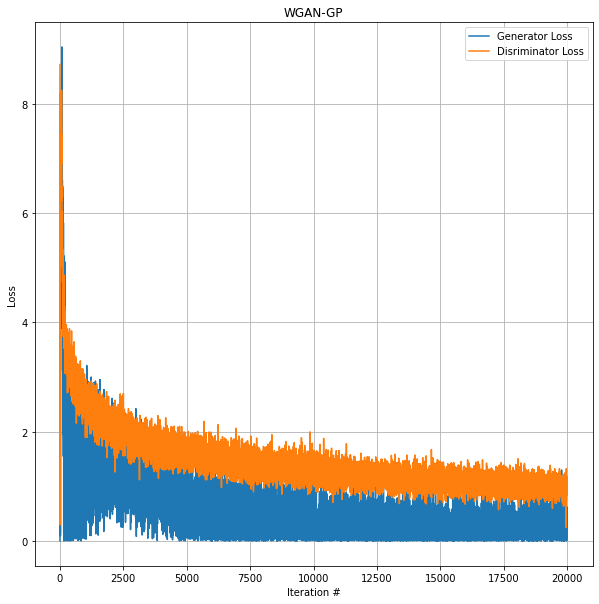

In [19]:
model_type = 'wgan-gp'
generator = Generator(mode=model_type).to(DEVICE)
discriminator = Discriminator(mode=model_type).to(DEVICE)

gen_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))

results = train_and_save(train_loader, generator, discriminator, gen_optimizer, disc_optimizer, model_type=model_type)
plot_results(results['train_generator_loss'], results['train_discriminator_loss'], GEN_ITER, model_type.upper())